In [1]:
!pip install xmltodict

In [2]:
import os
import cv2
import matplotlib.pyplot as plt
import xmltodict
import random
from os import listdir
from os.path import isfile, join
import torchvision 
import torch 
import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.datasets as datasets

In [3]:
def getImageNames():
    image_names = []
    for dirname, _, filenames in os.walk('Data'):
        for filename in filenames:
            fullpath = os.path.join(dirname, filename)
            extension = fullpath[len(fullpath) - 4:]
            if extension != '.xml':
                image_names.append(filename)
    return image_names


def get_path(image_name):
    
    home_path = 'Data/Data_Set_MD/'
    image_path = home_path + 'images/' + image_name
    
    if image_name[-4:] == 'jpeg':
        label_name = image_name[:-5] + '.xml'
    else:
        label_name = image_name[:-4] + '.xml'
    
    label_path = home_path + 'annotations/' + label_name
        
    return  image_path, label_path

In [4]:
def parse_xml(label_path):
    
    x = xmltodict.parse(open(label_path , 'rb'))
    item_list = x['annotation']['object']
    
    # when image has only one bounding box
    if not isinstance(item_list, list):
        item_list = [item_list]
        
    result = []
    
    for item in item_list:
        name = item['name']
        bndbox = [(int(item['bndbox']['xmin']), int(item['bndbox']['ymin'])),
                  (int(item['bndbox']['xmax']), int(item['bndbox']['ymax']))]       
        result.append((name, bndbox))
    
    size = [int(x['annotation']['size']['width']), 
            int(x['annotation']['size']['height'])]
    
    return result, size


def visualize_image(image_name, bndbox=True):
    
    image_path, label_path = get_path(image_name)
    
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    if bndbox:
        labels, size = parse_xml(label_path)
        thickness = int(sum(size)/400.)
        
        for label in labels:
            name, bndbox = label
            
            if name == 'with_mask':
                cv2.rectangle(image, bndbox[0], bndbox[1], (0, 255, 0), thickness)
            elif name == 'without_mask':
                cv2.rectangle(image, bndbox[0], bndbox[1], (255, 0, 0), thickness)
            else: # name == 'none'
                cv2.rectangle(image, bndbox[0], bndbox[1], (0, 0, 255), thickness)
    
    plt.figure(figsize=(20, 20))
    plt.subplot(1, 2, 1)
    plt.axis('off')
    plt.title(image_name)
    plt.imshow(image)
    plt.show()

In [5]:
image_names = getImageNames()

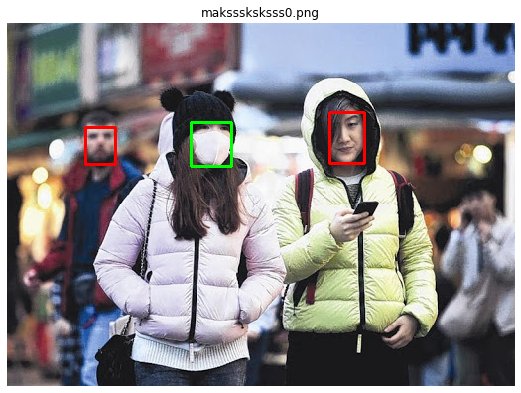

In [6]:
visualize_image(image_names[1])

In [8]:
NUM_OF_IMGS_TO_VISUALIZE = 3

for i in range(NUM_OF_IMGS_TO_VISUALIZE):
    visualize_image(image_names[i])

error: OpenCV(3.4.2) c:\miniconda3\conda-bld\opencv-suite_1534379934306\work\modules\imgproc\src\color.hpp:253: error: (-215:Assertion failed) VScn::contains(scn) && VDcn::contains(dcn) && VDepth::contains(depth) in function 'cv::CvtHelper<struct cv::Set<3,4,-1>,struct cv::Set<3,4,-1>,struct cv::Set<0,2,5>,2>::CvtHelper'


In [ ]:
def cropImage(image_name):
    image_path, label_path = get_path(image_name)
    
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    
    labels, size = parse_xml(label_path)
    
    cropedImgLabels = []

    for label in labels:
        name, bndbox = label
        
        
        croped_image = image[bndbox[0][1]:bndbox[1][1], bndbox[0][0]:bndbox[1][0]]
        
        label_num = 0
        
        if name == "with_mask":
            label_num = 0
        elif name == "without_mask":
            label_num = 1
        else:
            label_num = 2
        
        cropedImgLabel = [croped_image, label_num]
        
        cropedImgLabels.append(cropedImgLabel)
        
    return cropedImgLabels

In [ ]:
def createDirectory(dirname):
    try:
        os.mkdir(dirname)
    except FileExistsError:
        print("Directory " + dirname + " already exists.")

In [ ]:
dir_name = 'train/'
label_0_dir = dir_name + "0/"
label_1_dir = dir_name + "1/"
#label_2_dir = dir_name + "2/"
models_dir = "models/"


createDirectory(dir_name)
createDirectory(label_0_dir)
createDirectory(label_1_dir)
#createDirectory(label_2_dir)
createDirectory(models_dir)

In [ ]:
label_0_counter = 0
label_1_counter = 0
#label_2_counter = 0

for image_name in image_names:
    cropedImgLabels = cropImage(image_name)
    
    for cropedImgLabel in cropedImgLabels:
        
        label = cropedImgLabel[1]
        img = cropedImgLabel[0]
        
        if label == 0:
            croped_img_name = str(label_0_counter) + ".jpg"
            cv2.imwrite(label_0_dir + croped_img_name, img)
            label_0_counter += 1
        elif label == 1:
            croped_img_name = str(label_1_counter) + ".jpg"
            cv2.imwrite(label_1_dir + croped_img_name, img)
            label_1_counter += 1

In [ ]:
filenames_label_0 = [f for f in listdir(label_0_dir) if isfile(join(label_0_dir, f))]
filenames_label_1 = [f for f in listdir(label_1_dir) if isfile(join(label_1_dir, f))]

In [ ]:
print("Número Total de Imágenes: " + str(len(filenames_label_0) + len(filenames_label_1)))
print("Número Total de Imágenes marcadas como 0: " + str(len(filenames_label_0)))
print("Número Total de Imágenes marcadas como 1: " + str(len(filenames_label_1)))

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

## Modelo Resnet50

In [ ]:
#NO
model = models.resnet50(pretrained=True)

### Inicializar Fully Connected Layers

In [ ]:
#NO
for layer, param in model.named_parameters():
    
    if 'layer4' not in layer:
        param.requires_grad = False

model.fc = torch.nn.Sequential(torch.nn.Linear(2048, 512),
                                 torch.nn.ReLU(),
                                 torch.nn.Dropout(0.2),
                                 torch.nn.Linear(512, 2),
                                 torch.nn.LogSoftmax(dim=1))

In [ ]:
#SI
train_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
    ])

### Dividir los Datos

In [ ]:
#SI
from sklearn.utils import shuffle

dataset = datasets.ImageFolder(dir_name, transform = train_transforms)

dataset = shuffle(dataset)

dataset_size = len(dataset)
train_size = int(dataset_size * 0.6)
val_size = int(dataset_size * 0.2)
test_size = dataset_size - train_size - val_size

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

print('Tamaño del Dataset: ', len(dataset))
print('Tamaño del set de Train: ', len(train_dataset))
print('Tamaño del set de Validation: ', len(val_dataset))
print('Tamaño del set de Test: ', len(test_dataset))

### Initialize Loaders

In [ ]:
BATCH_SIZE = 20

train_loader = torch.utils.data.DataLoader(train_dataset,
                                          batch_size=BATCH_SIZE,
                                          shuffle=True)

val_loader = torch.utils.data.DataLoader(val_dataset,
                                          batch_size=BATCH_SIZE,
                                          shuffle=True)

test_loader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=BATCH_SIZE,
                                          shuffle=True)

### Loss and Optimizer Functions

In [ ]:
LEARNING_RATE = 0.001

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)

In [ ]:
#model.cuda()
model.to(device)

### Entrenamiento y Validación

In [ ]:
total_epoch = 20

best_epoch = 0
training_losses = []
val_losses = []


for epoch in range(total_epoch):
    
    epoch_train_loss = 0
    
    for X, y in train_loader:
        
        X, y = X.cuda(), y.cuda()
        
        optimizer.zero_grad()
        result = model(X)
        loss = criterion(result, y)
        epoch_train_loss += loss.item()
        loss.backward()
        optimizer.step()
      
    training_losses.append(epoch_train_loss)
    
    
    epoch_val_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for X, y in val_loader:
            
            X, y = X.cuda(), y.cuda()
             
            result = model(X)
            loss = criterion(result, y)
            epoch_val_loss += loss.item()
            _, maximum = torch.max(result.data, 1)
            total += y.size(0)
            correct += (maximum == y).sum().item()
            
    val_losses.append(epoch_val_loss)
    accuracy = correct/total
    print("EPOCH:", epoch, ", Training Loss:", epoch_train_loss, ", Validation Loss:", epoch_val_loss, ", Accuracy: ", accuracy)
    
    
    if min(val_losses) == val_losses[-1]:
        best_epoch = epoch
        checkpoint = {'model': model,
                            'state_dict': model.state_dict(),
                            'optimizer' : optimizer.state_dict()}

        torch.save(checkpoint, models_dir + '{}.pth'.format(epoch))
        print("Model saved")

## Visualización del Error de Entrenamiento y Validación

In [ ]:
plt.plot(range(total_epoch), training_losses, label='Training')
plt.plot(range(total_epoch), val_losses, label='Validation')
plt.legend()

### Loading the Existing Model

In [ ]:
def load_checkpoint(filepath):
    if torch.cuda.is_available():
        checkpoint = torch.load(filepath)
    else:
        checkpoint = torch.load(filepath, map_location=torch.device('cpu'))
    #checkpoint = torch.load(filepath)
    model = checkpoint['model']
    model.load_state_dict(checkpoint['state_dict'])
    for parameter in model.parameters():
        parameter.requires_grad = False
    
    return model.eval()


filepath = "models/2.pth"
loaded_model = load_checkpoint(filepath)

train_transforms = transforms.Compose([
                                       transforms.Resize((224,224)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
                                       ])

### Test

In [ ]:
correct = 0
total = 0
    
with torch.no_grad():
    for X, y in test_loader:

        #X, y = X.cuda(), y.cuda()

        result = loaded_model(X)
        _, maximum = torch.max(result.data, 1)
        total += y.size(0)
        correct += (maximum == y).sum().item()

accuracy = correct/total

print("\n")
print("------------")
print("Accuracy: " + str(accuracy))
print("------------")
print("\n")

### Detection

In [ ]:
!pip install cvlib

In [ ]:
import cvlib as cv
from PIL import Image
import imutils

cap = cv2.VideoCapture(0)

font_scale=1
thickness = 2
red = (0,0,255)
green = (0,255,0)
blue = (255,0,0)
font=cv2.FONT_HERSHEY_SIMPLEX

face_cascade = cv2.CascadeClassifier(r'haarcascade_frontalface_default.xml')
#face_cascade = cv2.CascadeClassifier(r'haarcascade_profileface_umist1.xml')

while(cap.isOpened()):
    ret, frame = cap.read()
    if ret == True:

        frame = imutils.resize(frame, width=640)
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray, 1.3, 5)
        
        for (x, y, w, h) in faces:
            
            cv2.rectangle(frame, (x, y), (x+w, y+h), blue, 2)
            
            croped_img = frame[y:y+h, x:x+w]
            pil_image = Image.fromarray(croped_img, mode = "RGB")
            pil_image = train_transforms(pil_image)
            image = pil_image.unsqueeze(0)
            
            image = image.to(device)
            
            result = loaded_model(image)
            _, maximum = torch.max(result.data, 1)
            prediction = maximum.item()

            
            if prediction == 0:
                cv2.putText(frame, "Masked", (x,y - 10), font, font_scale, green, thickness)
                cv2.rectangle(frame, (x, y), (x+w, y+h), green, 2)
            elif prediction == 1:
                cv2.putText(frame, "No Mask", (x,y - 10), font, font_scale, red, thickness)
                cv2.rectangle(frame, (x, y), (x+w, y+h), red, 2)
        
        cv2.imshow('frame',frame)
        
        if (cv2.waitKey(1) & 0xFF) == ord('q'):
            break
    else:
        break

cap.release()
cv2.destroyAllWindows()

### Prueba en imagen estática

In [ ]:
#Prueba en imagen estática
croped_img = cv2.imread("test.jpg")
    
pil_image = Image.fromarray(croped_img, mode = "RGB")
pil_image = train_transforms(pil_image)
image = pil_image.unsqueeze(0)


#result = loaded_model(image.to("cuda:0"))
result = loaded_model(image)#.to("cuda:0"))
m, maximum = torch.max(result.data, 1)
prediction = maximum.item()
print("Maximum: ", result.data, " ", prediction, m)

In [ ]:
imagen_prueba = cv2.imread("test.jpg")
imagen_prueba = cv2.cvtColor(imagen_prueba, cv2.COLOR_BGR2RGB)
plt.imshow(imagen_prueba)

if prediction == 0:
    result =  "con mascarilla" 
else: 
    result = "sin mascarilla"

print("Prediccion: ", result)

## Para el tiempo (aún no implementado)

In [ ]:
#Librería
import time
#Inicio contador
start = time.time()

#Fin contrador
end = time.time()

#Tiempo en string porque sino no podremos mostrarlo en la pantalla
m, s = divmod(end - start, 60)
h, m = divmod(m, 60)
time_str = "%02d:%02d:%02d" % (h, m, s)

#como agregar el tiempo al frame
cv2.putText(frame, 'Time '+time_str, (x,y - 30), font, font_scale2, green, thickness)

#Libería con metricas de tiempo
!pip install pythonbenchmark